# Proyecto HAR: Clasificacion de Actividades Humanas
## Red Neuronal Hibrida CNN-1D + MLP

**Objetivo**: Clasificar 6 actividades humanas usando datos de sensores inerciales (acelerometro + giroscopio)

**Actividades a clasificar**:
1. WALKING (Caminando)
2. WALKING_UPSTAIRS (Subiendo escaleras)
3. WALKING_DOWNSTAIRS (Bajando escaleras)
4. SITTING (Sentado)
5. STANDING (De pie)
6. LAYING (Acostado)

---

# 1. Configuracion del Entorno

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Configuracion de graficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
%matplotlib inline

# Reproducibilidad: fijamos las semillas
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*70)
print("CONFIGURACION DEL ENTORNO")
print("="*70)
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("="*70)

CONFIGURACION DEL ENTORNO
PyTorch version: 2.9.0+cu126
Device: cuda
GPU: Tesla T4


# 2. Carga de Datos Inerciales

### Origen del Dataset
El dataset proviene del proyecto **UCI HAR Dataset** (Human Activity Recognition Using Smartphones).

**Contexto del experimento:**
- 30 voluntarios (19-48 años)
- Dispositivo: Samsung Galaxy S II en la cintura
- Sensores: Acelerometro y giroscopio a 50Hz
- Ventanas: 2.56 segundos con 50% overlap (128 lecturas por ventana)

### Estructura de los datos
Usamos las **senales crudas** (no las 561 features pre-calculadas) porque queremos que la CNN aprenda sus propias caracteristicas.

**Archivos utilizados** (9 senales por conjunto):
- `body_acc_x/y/z`: Aceleracion del cuerpo (sin gravedad)
- `body_gyro_x/y/z`: Velocidad angular
- `total_acc_x/y/z`: Aceleracion total (con gravedad)

### Tensor 3D de entrada
Nuestros datos forman un tensor de orden 3: $X \in \mathbb{R}^{N \times C \times T}$

- **N** (samples): Numero de muestras
- **C** (channels): 9 canales de sensores
- **T** (timesteps): 128 pasos temporales (2.56 segundos a 50Hz)

In [3]:
# Ruta base de los datos
BASE_PATH = '/content/drive/MyDrive/analitica/data'

# Nombres de los archivos de senales
signal_files = [
    'body_acc_x', 'body_acc_y', 'body_acc_z',
    'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
    'total_acc_x', 'total_acc_y', 'total_acc_z'
]

def load_signals(subset):

    signals = []

    for signal_name in signal_files:
        filename = f'{signal_name}_{subset}.txt'
        filepath = os.path.join(BASE_PATH, subset, 'data_train', filename)

        # Cada archivo tiene N filas x 128 columnas (timesteps)
        signal = np.loadtxt(filepath)
        signals.append(signal)

    # Apilar en un tensor 3D: (N, 9, 128)
    X = np.stack(signals, axis=1)
    return X

def load_labels(subset):

    filepath = os.path.join(BASE_PATH, subset, f'y_{subset}.txt')
    y = np.loadtxt(filepath, dtype=int)
    return y - 1  # Convertir a indices 0-5

# Cargar datos
print("Cargando datos de entrenamiento...")
X_train = load_signals('train')
y_train = load_labels('train')

print("Cargando datos de test...")
X_test = load_signals('test')
y_test = load_labels('test')

print("\n" + "="*70)
print("DATOS CARGADOS EXITOSAMENTE")
print("="*70)
print(f"X_train shape: {X_train.shape} -> (muestras, canales, timesteps)")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")
print("="*70)

Cargando datos de entrenamiento...
Cargando datos de test...

DATOS CARGADOS EXITOSAMENTE
X_train shape: (7352, 9, 128) -> (muestras, canales, timesteps)
y_train shape: (7352,)
X_test shape:  (2947, 9, 128)
y_test shape:  (2947,)


# 3. Analisis Exploratorio de Datos (EDA)

Antes de visualizar los datos, realizamos un analisis numerico para entender:
- Dimensiones y tipos de datos
- Estadisticas descriptivas por canal
- Distribucion de clases
- Correlaciones entre canales

### Por que usamos total_acc Y body_acc?

**No es redundante, es complementario:**

| Senal | Que mide | Informacion que aporta |
|-------|----------|------------------------|
| **total_acc** | Aceleracion total (con gravedad) | Orientacion del dispositivo (la gravedad siempre apunta hacia abajo) |
| **body_acc** | Aceleracion del cuerpo (sin gravedad) | Movimiento puro del usuario |

**Ejemplo practico:**
- LAYING: total_acc_z ~ 1g (gravedad en Z), body_acc ~ 0 (sin movimiento)
- STANDING: total_acc_y ~ 1g (gravedad en Y), body_acc ~ 0 (sin movimiento)
- WALKING: total_acc_y ~ 1g (gravedad en Y), body_acc = oscilaciones ritmicas (pasos)

## 3.1 Informacion General del Dataset

In [4]:
# Informacion general del dataset
print("="*70)
print("INFORMACION GENERAL DEL DATASET")
print("="*70)

print("\n[Dimensiones]")
print(f"  Muestras de entrenamiento: {X_train.shape[0]:,}")
print(f"  Muestras de test:          {X_test.shape[0]:,}")
print(f"  Total de muestras:         {X_train.shape[0] + X_test.shape[0]:,}")
print(f"  Canales (senales):         {X_train.shape[1]}")
print(f"  Timesteps por muestra:     {X_train.shape[2]}")

print("\n[Tipos de datos]")
print(f"  X_train dtype: {X_train.dtype}")
print(f"  y_train dtype: {y_train.dtype}")

print("\n[Rango de valores]")
print(f"  X_train: min={X_train.min():.4f}, max={X_train.max():.4f}")
print(f"  y_train: valores unicos = {np.unique(y_train)}")

print("\n[Memoria]")
print(f"  X_train: {X_train.nbytes / 1024 / 1024:.2f} MB")
print(f"  X_test:  {X_test.nbytes / 1024 / 1024:.2f} MB")

INFORMACION GENERAL DEL DATASET

[Dimensiones]
  Muestras de entrenamiento: 7,352
  Muestras de test:          2,947
  Total de muestras:         10,299
  Canales (senales):         9
  Timesteps por muestra:     128

[Tipos de datos]
  X_train dtype: float64
  y_train dtype: int64

[Rango de valores]
  X_train: min=-5.9743, max=5.7461
  y_train: valores unicos = [0 1 2 3 4 5]

[Memoria]
  X_train: 64.62 MB
  X_test:  25.90 MB


## 3.2 Estadisticas Descriptivas por Canal

In [5]:
# Nombres de los canales
channel_names = [
    'body_acc_x', 'body_acc_y', 'body_acc_z',
    'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
    'total_acc_x', 'total_acc_y', 'total_acc_z'
]

# Crear DataFrame con estadisticas por canal
stats_data = []
for i, name in enumerate(channel_names):
    channel_data = X_train[:, i, :].flatten()
    stats_data.append({
        'Canal': name,
        'Media': channel_data.mean(),
        'Std': channel_data.std(),
        'Min': channel_data.min(),
        'Q25': np.percentile(channel_data, 25),
        'Mediana': np.median(channel_data),
        'Q75': np.percentile(channel_data, 75),
        'Max': channel_data.max()
    })

stats_df = pd.DataFrame(stats_data)

print("="*70)
print("ESTADISTICAS DESCRIPTIVAS POR CANAL")
print("="*70)
print(stats_df.to_string(index=False, float_format='{:.4f}'.format))

print("\n[Observaciones]")
print("  - body_acc tiene media cercana a 0 (se resto la gravedad)")
print("  - total_acc_x tiene media ~0.8 (componente de gravedad)")
print("  - body_gyro tiene mayor variabilidad que body_acc")

ESTADISTICAS DESCRIPTIVAS POR CANAL
      Canal   Media    Std     Min     Q25  Mediana    Q75    Max
 body_acc_x -0.0006 0.1948 -1.2322 -0.0277  -0.0007 0.0074 1.2999
 body_acc_y -0.0003 0.1224 -1.3453 -0.0107   0.0007 0.0220 0.9760
 body_acc_z -0.0003 0.1069 -1.3647 -0.0156   0.0001 0.0155 1.0669
body_gyro_x  0.0005 0.4068 -4.7337 -0.0443   0.0001 0.0548 4.1555
body_gyro_y -0.0008 0.3819 -5.9743 -0.0551  -0.0006 0.0370 5.7461
body_gyro_z  0.0001 0.2557 -2.7630 -0.0253   0.0005 0.0495 2.3660
total_acc_x  0.8047 0.4141 -0.4666  0.6649   0.9560 1.0192 2.1976
total_acc_y  0.0288 0.3910 -1.5821 -0.2206  -0.0813 0.1913 1.2173
total_acc_z  0.0865 0.3578 -1.6396 -0.1312   0.0391 0.2390 1.2814

[Observaciones]
  - body_acc tiene media cercana a 0 (se resto la gravedad)
  - total_acc_x tiene media ~0.8 (componente de gravedad)
  - body_gyro tiene mayor variabilidad que body_acc


## 3.3 Distribucion de Clases

In [6]:
# Nombres de las actividades
activity_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS',
                  'SITTING', 'STANDING', 'LAYING']

# Contar muestras por clase
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("="*70)
print("DISTRIBUCION DE CLASES")
print("="*70)

print("\n[Conjunto de Entrenamiento]")
print("-"*70)
for i, (label, count) in enumerate(zip(activity_names, counts_train)):
    percentage = (count / len(y_train)) * 100
    bar = '#' * int(percentage / 2)
    print(f"  {i}: {label:20s} | {count:4d} ({percentage:5.2f}%) {bar}")

print(f"\n  Total: {len(y_train):,} muestras")

print("\n[Conjunto de Test]")
print("-"*70)
for i, (label, count) in enumerate(zip(activity_names, counts_test)):
    percentage = (count / len(y_test)) * 100
    bar = '#' * int(percentage / 2)
    print(f"  {i}: {label:20s} | {count:4d} ({percentage:5.2f}%) {bar}")

print(f"\n  Total: {len(y_test):,} muestras")

# Verificar balance
min_pct = min(counts_train) / len(y_train) * 100
max_pct = max(counts_train) / len(y_train) * 100
print(f"\n[Conclusion]")
print(f"  Rango de porcentajes: {min_pct:.1f}% - {max_pct:.1f}%")
print(f"  Las clases estan relativamente balanceadas (sin desbalance severo).")
print(f"  Esto significa que el accuracy es una metrica confiable.")

DISTRIBUCION DE CLASES

[Conjunto de Entrenamiento]
----------------------------------------------------------------------
  0: WALKING              | 1226 (16.68%) ########
  1: WALKING_UPSTAIRS     | 1073 (14.59%) #######
  2: WALKING_DOWNSTAIRS   |  986 (13.41%) ######
  3: SITTING              | 1286 (17.49%) ########
  4: STANDING             | 1374 (18.69%) #########
  5: LAYING               | 1407 (19.14%) #########

  Total: 7,352 muestras

[Conjunto de Test]
----------------------------------------------------------------------
  0: WALKING              |  496 (16.83%) ########
  1: WALKING_UPSTAIRS     |  471 (15.98%) #######
  2: WALKING_DOWNSTAIRS   |  420 (14.25%) #######
  3: SITTING              |  491 (16.66%) ########
  4: STANDING             |  532 (18.05%) #########
  5: LAYING               |  537 (18.22%) #########

  Total: 2,947 muestras

[Conclusion]
  Rango de porcentajes: 13.4% - 19.1%
  Las clases estan relativamente balanceadas (sin desbalance severo).
  E

## 3.4 Correlaciones entre Canales

In [7]:
# Calcular correlaciones entre canales
# Promediamos cada canal sobre el tiempo para obtener un valor por muestra
channel_means = np.mean(X_train, axis=2)  # (N, 9)

# Crear DataFrame para correlaciones
corr_df = pd.DataFrame(channel_means, columns=channel_names)
correlation_matrix = corr_df.corr()

print("="*70)
print("MATRIZ DE CORRELACIONES ENTRE CANALES")
print("="*70)
print("(Valores promediados por muestra)")
print()

# Mostrar correlaciones significativas (|r| > 0.5)
print("[Correlaciones significativas (|r| > 0.5)]")
print("-"*70)
for i in range(len(channel_names)):
    for j in range(i+1, len(channel_names)):
        corr = correlation_matrix.iloc[i, j]
        if abs(corr) > 0.5:
            print(f"  {channel_names[i]:15s} <-> {channel_names[j]:15s}: r = {corr:+.3f}")

print("\n[Observaciones]")
print("  - Los ejes del mismo sensor pueden estar correlacionados")
print("  - body_acc y total_acc difieren por el componente de gravedad")

MATRIZ DE CORRELACIONES ENTRE CANALES
(Valores promediados por muestra)

[Correlaciones significativas (|r| > 0.5)]
----------------------------------------------------------------------
  body_gyro_x     <-> body_gyro_y    : r = -0.740
  total_acc_x     <-> total_acc_y    : r = -0.798
  total_acc_x     <-> total_acc_z    : r = -0.664
  total_acc_y     <-> total_acc_z    : r = +0.661

[Observaciones]
  - Los ejes del mismo sensor pueden estar correlacionados
  - body_acc y total_acc difieren por el componente de gravedad


# 4. Visualizacion de Datos

Ahora que entendemos numericamente los datos, los visualizamos para obtener intuicion sobre los patrones.

## 4.1 Distribucion de Clases (Grafico de Barras)

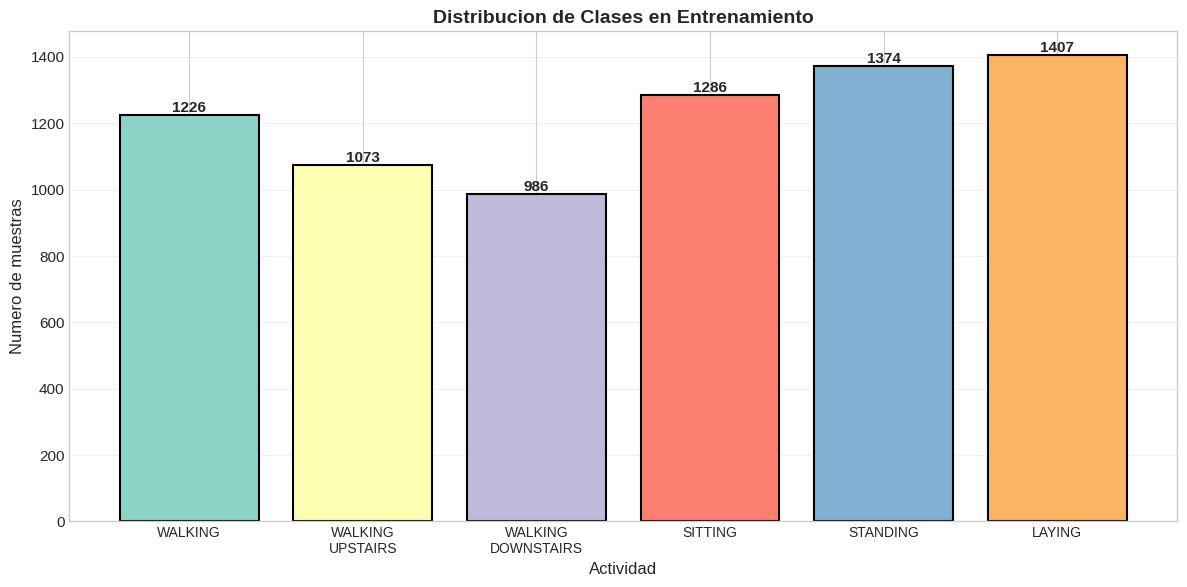

[Observacion]
  Las clases estan balanceadas (16-19% cada una).
  No hay necesidad de tecnicas de balanceo como oversampling.


In [8]:
# Grafico de distribucion de clases
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.Set3(range(6))
bars = ax.bar(range(6), counts_train, color=colors, edgecolor='black', linewidth=1.5)

ax.set_title('Distribucion de Clases en Entrenamiento', fontsize=14, weight='bold')
ax.set_xlabel('Actividad', fontsize=12)
ax.set_ylabel('Numero de muestras', fontsize=12)
ax.set_xticks(range(6))
ax.set_xticklabels([name.replace('_', '\n') for name in activity_names], fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for bar, count in zip(bars, counts_train):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}',
            ha='center', va='bottom', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()

print("[Observacion]")
print("  Las clases estan balanceadas (16-19% cada una).")
print("  No hay necesidad de tecnicas de balanceo como oversampling.")

## 4.2 Senales del Acelerometro Body (Ejemplo: WALKING)

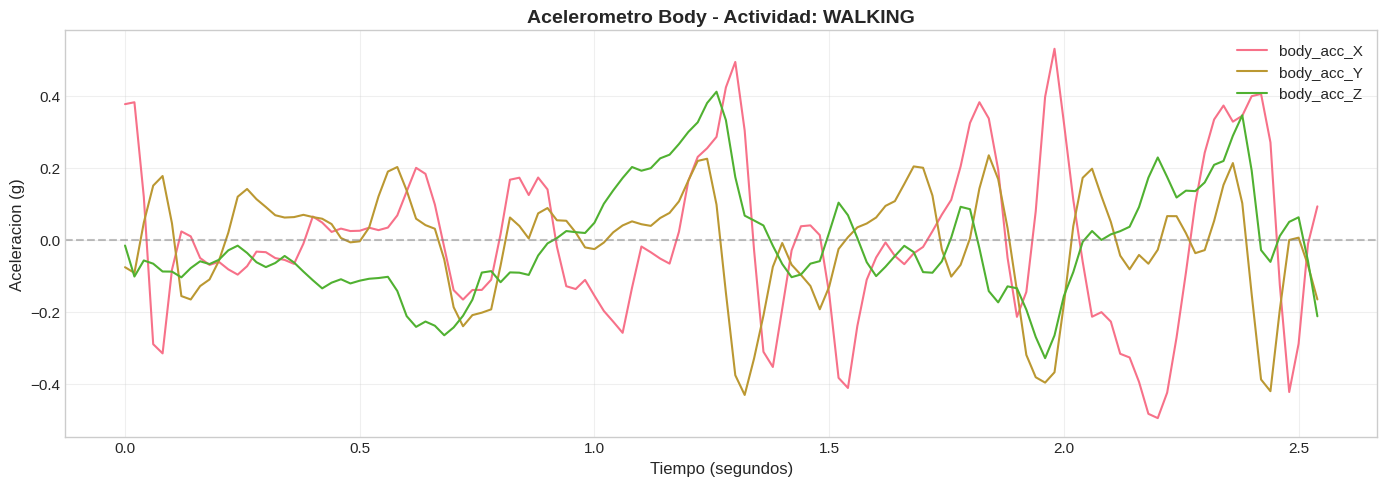

[Observacion]
  Se observan patrones periodicos que corresponden a los pasos.
  El eje Y muestra mayor amplitud (movimiento vertical al caminar).


In [9]:
# Seleccionar una muestra de WALKING (clase 0)
idx_walking = np.where(y_train == 0)[0][0]
sample = X_train[idx_walking]

# Grafico: Acelerometro Body
fig, ax = plt.subplots(figsize=(14, 5))

time = np.arange(128) / 50  # Convertir a segundos (50 Hz)

for i, axis_name in enumerate(['X', 'Y', 'Z']):
    ax.plot(time, sample[i], label=f'body_acc_{axis_name}', linewidth=1.5)

ax.set_title('Acelerometro Body - Actividad: WALKING', fontsize=14, weight='bold')
ax.set_xlabel('Tiempo (segundos)', fontsize=12)
ax.set_ylabel('Aceleracion (g)', fontsize=12)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 4.3 Senales del Giroscopio (Ejemplo: WALKING)

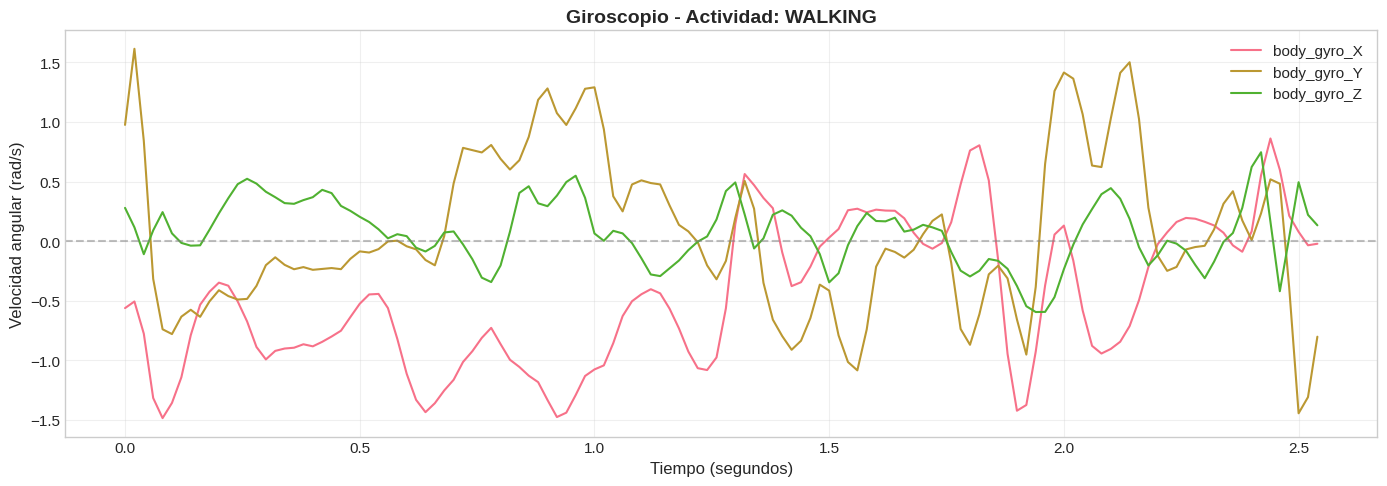

[Observacion]
  El giroscopio mide rotacion del dispositivo.
  Se observan oscilaciones que corresponden al balanceo del cuerpo.


In [10]:
# Grafico: Giroscopio
fig, ax = plt.subplots(figsize=(14, 5))

for i, axis_name in enumerate(['X', 'Y', 'Z']):
    ax.plot(time, sample[i+3], label=f'body_gyro_{axis_name}', linewidth=1.5)

ax.set_title('Giroscopio - Actividad: WALKING', fontsize=14, weight='bold')
ax.set_xlabel('Tiempo (segundos)', fontsize=12)
ax.set_ylabel('Velocidad angular (rad/s)', fontsize=12)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 4.4 Comparacion: body_acc vs total_acc

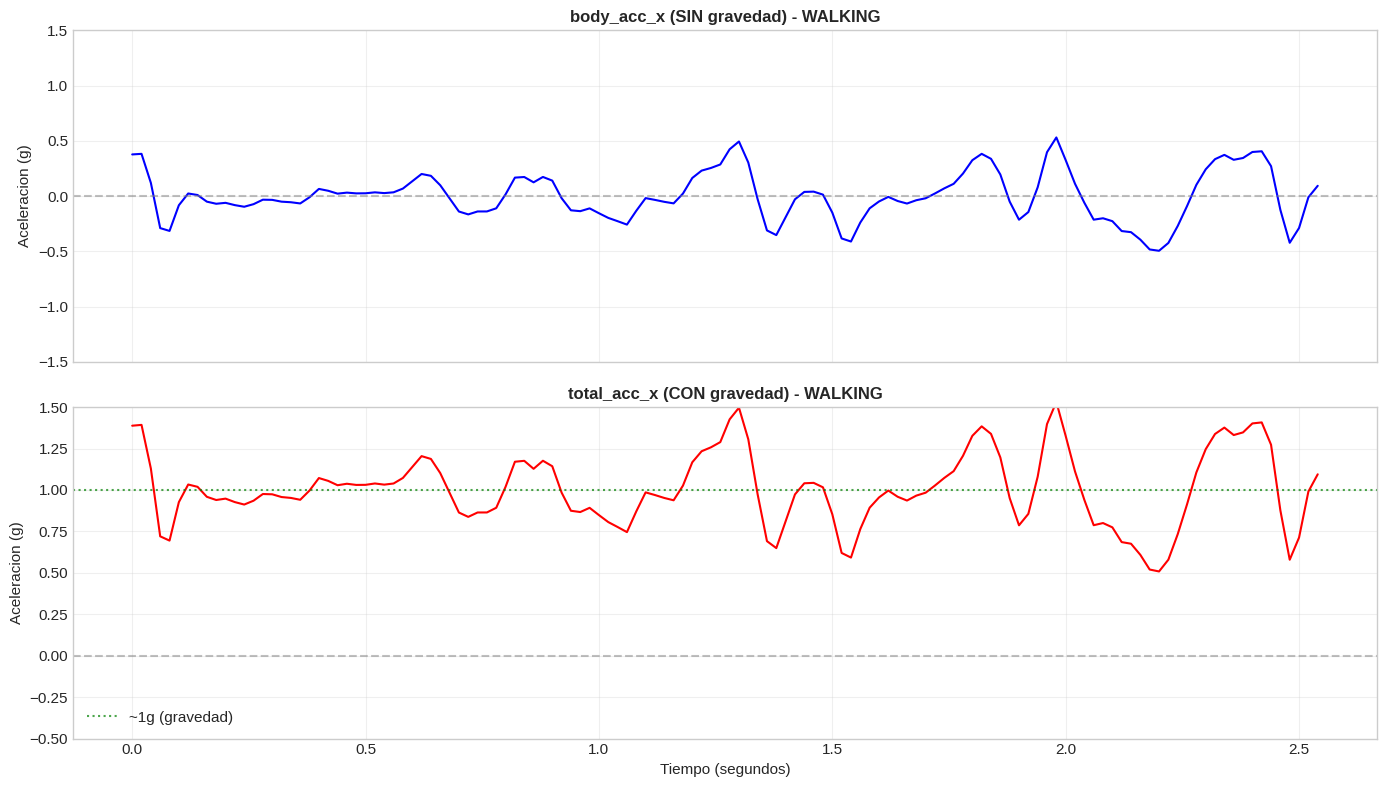

[Observacion]
  body_acc oscila alrededor de 0 (se resto el componente de gravedad).
  total_acc tiene un offset de ~1g por la gravedad.
  La diferencia revela la orientacion del dispositivo.


In [11]:
# Comparar body_acc_x vs total_acc_x
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# body_acc_x
axes[0].plot(time, sample[0], 'b-', linewidth=1.5)
axes[0].set_title('body_acc_x (SIN gravedad) - WALKING', fontsize=12, weight='bold')
axes[0].set_ylabel('Aceleracion (g)')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-1.5, 1.5)

# total_acc_x
axes[1].plot(time, sample[6], 'r-', linewidth=1.5)
axes[1].set_title('total_acc_x (CON gravedad) - WALKING', fontsize=12, weight='bold')
axes[1].set_xlabel('Tiempo (segundos)')
axes[1].set_ylabel('Aceleracion (g)')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(y=1, color='green', linestyle=':', alpha=0.7, label='~1g (gravedad)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

## 4.5 Heatmap de Todos los Canales

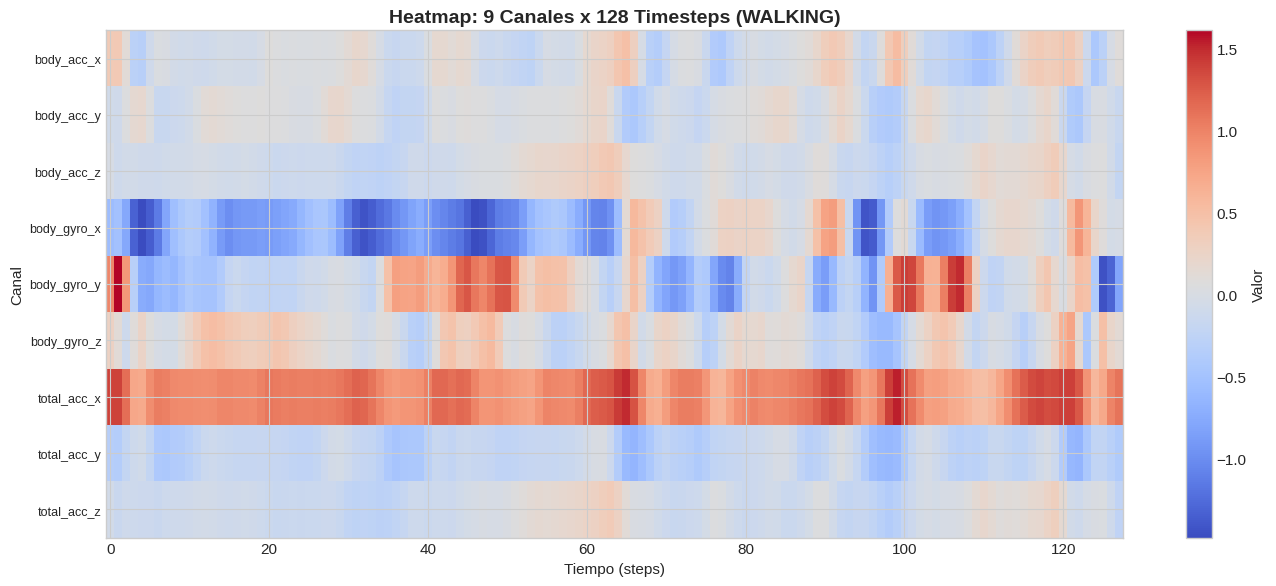

[Observacion]
  Cada fila es una senal de sensor, cada columna un instante de tiempo.
  Los patrones verticales indican correlacion temporal entre canales.
  total_acc muestra un offset constante (color diferente).


In [12]:
# Heatmap de todos los canales para una muestra
fig, ax = plt.subplots(figsize=(14, 6))

im = ax.imshow(sample, cmap='coolwarm', aspect='auto')
ax.set_title('Heatmap: 9 Canales x 128 Timesteps (WALKING)', fontsize=14, weight='bold')
ax.set_xlabel('Tiempo (steps)')
ax.set_ylabel('Canal')
ax.set_yticks(range(9))
ax.set_yticklabels(channel_names, fontsize=9)
plt.colorbar(im, ax=ax, label='Valor')

plt.tight_layout()
plt.show()

## 4.6 Matriz de Correlaciones (Heatmap)

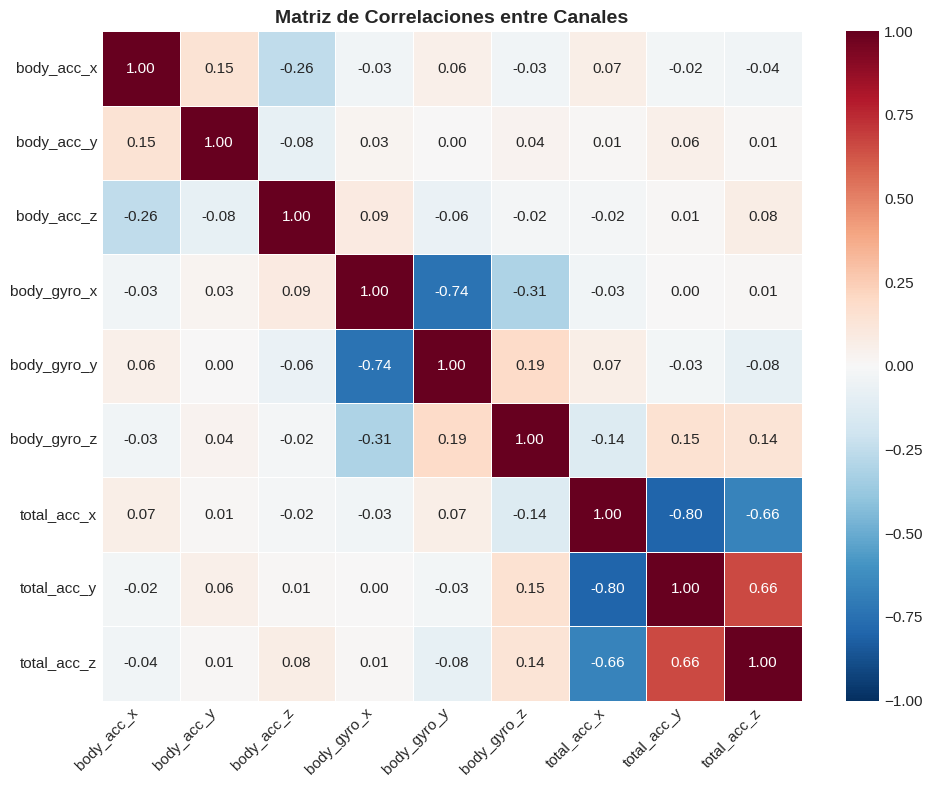

[Observacion]
  Diagonal = 1 (cada variable esta perfectamente correlacionada consigo misma).
  Rojo = correlacion positiva, Azul = correlacion negativa.


In [13]:
# Heatmap de correlaciones
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1,
            xticklabels=channel_names, yticklabels=channel_names,
            ax=ax, linewidths=0.5)

ax.set_title('Matriz de Correlaciones entre Canales', fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

## 4.7 Comparacion de Senales por Actividad

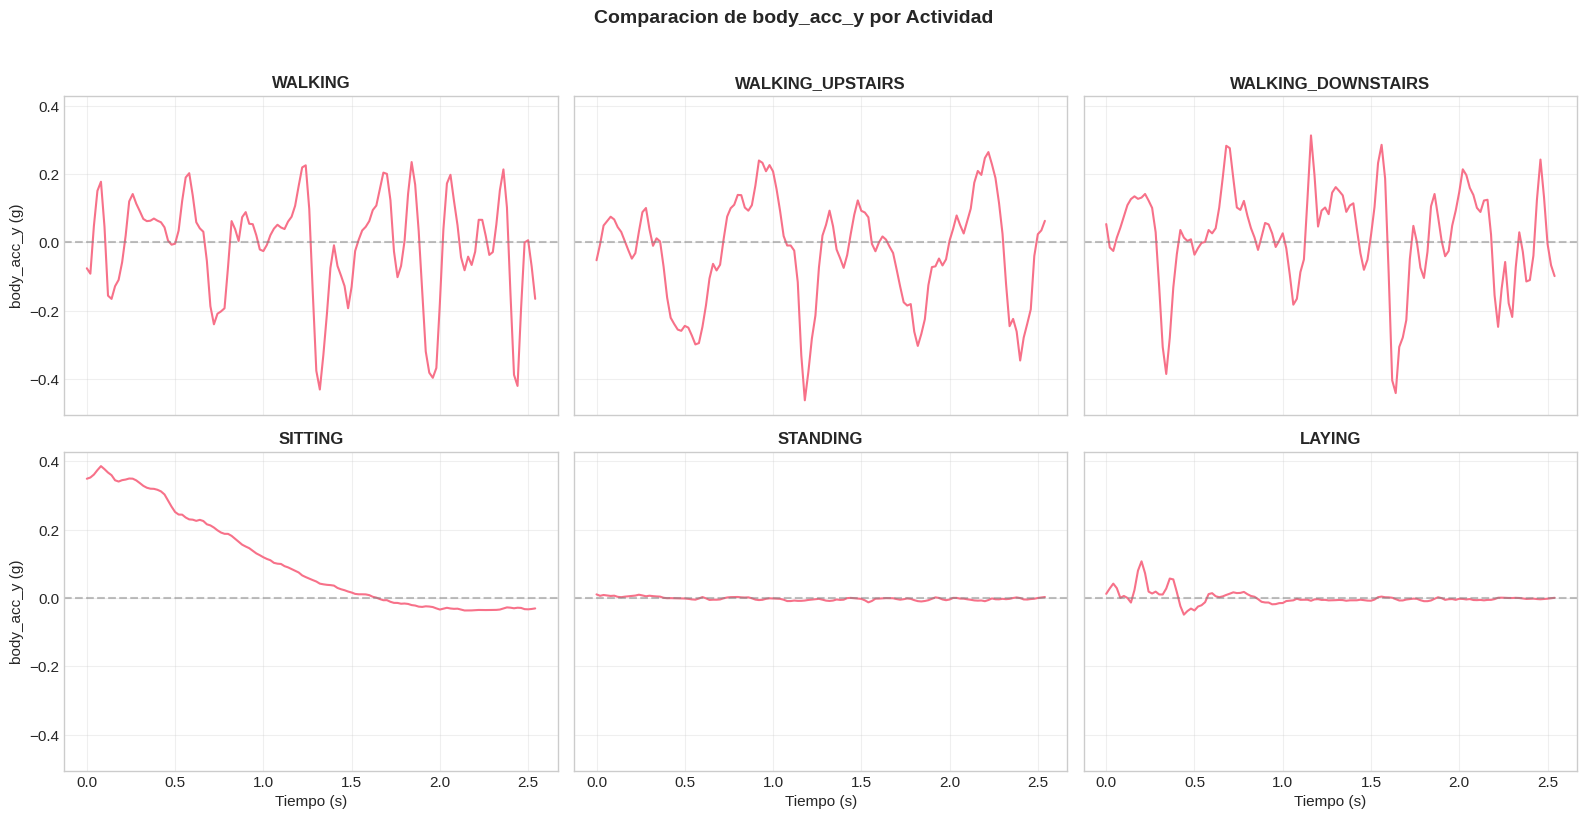

[Observacion]
  Actividades dinamicas (WALKING, UPSTAIRS, DOWNSTAIRS): oscilaciones claras.
  Actividades estaticas (SITTING, STANDING, LAYING): senales casi planas.
  Esta diferencia es lo que la CNN aprende a detectar.


In [14]:
# Comparar body_acc_y para diferentes actividades
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, activity in enumerate(activity_names):
    # Obtener primera muestra de esta clase
    idx = np.where(y_train == i)[0][0]
    sample_activity = X_train[idx]

    ax = axes[i]
    ax.plot(time, sample_activity[1], linewidth=1.5)  # body_acc_y
    ax.set_title(f'{activity}', fontsize=12, weight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    if i >= 3:
        ax.set_xlabel('Tiempo (s)')
    if i % 3 == 0:
        ax.set_ylabel('body_acc_y (g)')

plt.suptitle('Comparacion de body_acc_y por Actividad', fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 5. Dataset Personalizado y DataLoaders

### Conceptos:

- **Dataset**: Encapsula datos y etiquetas. Debe implementar `__len__` y `__getitem__`.
- **DataLoader**: Crea mini-batches para entrenamiento.
- **Batch**: Subconjunto aleatorio de datos. Reduce la varianza del gradiente.
- **Shuffle**: Aleatoriza el orden para evitar sesgos.
- **Train/Validation split**: 80% entrenamiento, 20% validacion (para early stopping).

In [15]:
class HARDataset(Dataset):
    """
    Dataset personalizado para HAR.

    Hereda de torch.utils.data.Dataset y debe implementar:
    - __len__: retorna el numero de muestras
    - __getitem__: retorna una muestra y su etiqueta
    """
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)  # (N, 9, 128)
        self.y = torch.LongTensor(y)   # (N,) - indices de clase

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Crear datasets completos
train_full_dataset = HARDataset(X_train, y_train)
test_dataset = HARDataset(X_test, y_test)

# Split train -> train + validation (80/20)
train_size = int(0.8 * len(train_full_dataset))
val_size = len(train_full_dataset) - train_size
train_dataset, val_dataset = random_split(train_full_dataset, [train_size, val_size])

# Crear DataLoaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("="*70)
print("DATASETS Y DATALOADERS")
print("="*70)
print(f"Train:      {len(train_dataset):5d} muestras -> {len(train_loader):4d} batches")
print(f"Validation: {len(val_dataset):5d} muestras -> {len(val_loader):4d} batches")
print(f"Test:       {len(test_dataset):5d} muestras -> {len(test_loader):4d} batches")
print(f"\nBatch size: {batch_size}")
print("="*70)

# Verificar shape de un batch
X_batch, y_batch = next(iter(train_loader))
print(f"\nShape de un batch:")
print(f"  X_batch: {X_batch.shape} -> (batch_size, channels, timesteps)")
print(f"  y_batch: {y_batch.shape} -> (batch_size,)")

DATASETS Y DATALOADERS
Train:       5881 muestras ->   92 batches
Validation:  1471 muestras ->   23 batches
Test:        2947 muestras ->   47 batches

Batch size: 64

Shape de un batch:
  X_batch: torch.Size([64, 9, 128]) -> (batch_size, channels, timesteps)
  y_batch: torch.Size([64]) -> (batch_size,)


# 6. Arquitectura CNN-1D + MLP

## Fundamentos Matematicos:

### Convolucion 1D (Algebra Lineal):
$$
(x * w)[t] = \sum_{k=0}^{K-1} x[t+k] \cdot w[k]
$$
- **Interpretacion**: Producto punto deslizante entre filtro y senal
- **Objetivo**: Detectar patrones temporales locales

### Max Pooling:
$$
\text{MaxPool}(x, k)[i] = \max_{j=0}^{k-1} x[i \cdot k + j]
$$
- **Objetivo**: Reduce dimensionalidad conservando caracteristicas mas fuertes

### Batch Normalization (Estadistica):
$$
\hat{x} = \frac{x - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$
- **Interpretacion**: Z-score aplicado dinamicamente

### Capa Lineal (Algebra Lineal):
$$
y = W \cdot x + b
$$

### ReLU (Activacion):
$$
\text{ReLU}(x) = \max(0, x)
$$

### Dropout (Regularizacion):
- Apaga neuronas aleatoriamente con probabilidad $p$ para evitar overfitting

In [16]:
class HARModel(nn.Module):
    """
    Arquitectura Hibrida CNN-1D + MLP para HAR

    Flujo de dimensiones:
    Input (B, 9, 128)
    -> Conv1d + BatchNorm + ReLU + MaxPool -> (B, 64, 64)
    -> Conv1d + BatchNorm + ReLU + MaxPool -> (B, 128, 32)
    -> Flatten -> (B, 4096)
    -> Linear + ReLU + Dropout -> (B, 256)
    -> Linear -> (B, 6)
    """
    def __init__(self, n_channels=9, n_classes=6):
        super(HARModel, self).__init__()

        # BLOQUE CNN-1D
        # Conv1: detecta patrones simples (bordes, picos)
        self.conv1 = nn.Conv1d(n_channels, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)

        # Conv2: detecta patrones mas complejos (combinaciones)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)

        # Pooling: reduce dimension temporal a la mitad
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Dropout: regularizacion
        self.dropout = nn.Dropout(0.3)

        # BLOQUE MLP
        # Calculo de dimension despues de convs:
        # 128 -> pool -> 64 -> pool -> 32
        # Canales finales: 128
        # Flattened size: 128 * 32 = 4096
        self.fc1 = nn.Linear(128 * 32, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        # x shape: (B, 9, 128)

        # Bloque Conv 1
        x = self.conv1(x)           # (B, 64, 128)
        x = self.bn1(x)             # Normalizacion
        x = F.relu(x)               # Activacion
        x = self.pool(x)            # (B, 64, 64)

        # Bloque Conv 2
        x = self.conv2(x)           # (B, 128, 64)
        x = self.bn2(x)             # Normalizacion
        x = F.relu(x)               # Activacion
        x = self.pool(x)            # (B, 128, 32)

        # Flatten: convertir tensor 3D a 2D
        x = x.view(x.size(0), -1)   # (B, 4096)

        # MLP
        x = self.fc1(x)             # (B, 256)
        x = F.relu(x)               # Activacion
        x = self.dropout(x)         # Regularizacion

        x = self.fc2(x)             # (B, 6) - Logits

        return x

# Crear modelo
model = HARModel(n_channels=9, n_classes=6).to(device)

print("="*70)
print("ARQUITECTURA DEL MODELO")
print("="*70)
print(model)
print("="*70)

# Contar parametros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nParametros del modelo:")
print(f"  Total:       {total_params:,}")
print(f"  Entrenables: {trainable_params:,}")

ARQUITECTURA DEL MODELO
HARModel(
  (conv1): Conv1d(9, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)

Parametros del modelo:
  Total:       1,094,790
  Entrenables: 1,094,790


In [17]:
# Test forward pass
model.eval()
with torch.no_grad():
    X_test_batch = X_batch.to(device)
    output = model(X_test_batch)

print("Test Forward Pass:")
print("-"*70)
print(f"Input shape:  {X_test_batch.shape}")
print(f"Output shape: {output.shape}")
print(f"\nOutput (logits) de la primera muestra:")
print(output[0].cpu().numpy())
print(f"\nProbabilidades (despues de softmax):")
probs = F.softmax(output[0], dim=0).cpu().numpy()
for i, (activity, prob) in enumerate(zip(activity_names, probs)):
    print(f"  {activity:20s}: {prob:.4f}")
print(f"\nClase predicha: {activity_names[output[0].argmax().item()]}")

Test Forward Pass:
----------------------------------------------------------------------
Input shape:  torch.Size([64, 9, 128])
Output shape: torch.Size([64, 6])

Output (logits) de la primera muestra:
[-0.03687443  0.07027653  0.09547532  0.01042374  0.00250049  0.05189424]

Probabilidades (despues de softmax):
  WALKING             : 0.1554
  WALKING_UPSTAIRS    : 0.1729
  WALKING_DOWNSTAIRS  : 0.1774
  SITTING             : 0.1629
  STANDING            : 0.1616
  LAYING              : 0.1698

Clase predicha: WALKING_DOWNSTAIRS


# 7. Entrenamiento del Modelo

## Fundamentos Matematicos:

### Cross-Entropy Loss (Teoria de la Informacion):
$$
L = -\sum_{c=1}^{C} y_c \log(\hat{p}_c)
$$
- $y_c$: etiqueta real (1 si es la clase correcta, 0 si no)
- $\hat{p}_c$: probabilidad predicha para clase $c$

### Backpropagation (Calculo - Regla de la Cadena):
$$
\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial f_3} \cdot \frac{\partial f_3}{\partial f_2} \cdot \frac{\partial f_2}{\partial f_1} \cdot \frac{\partial f_1}{\partial W_1}
$$

### Adam Optimizer:
$$
\theta_{t+1} = \theta_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$
- $\hat{m}_t$: momento de primer orden (media movil del gradiente)
- $\hat{v}_t$: momento de segundo orden (media movil del gradiente al cuadrado)

In [18]:
def train_epoch(model, loader, criterion, optimizer, device):
    """
    Entrena el modelo por una epoca.

    Returns:
        (avg_loss, accuracy)
    """
    model.train()  # Modo entrenamiento (activa dropout, batch norm training)
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)              # (B, 6) logits
        loss = criterion(outputs, y_batch)    # Cross-entropy

        # Backward pass (backpropagation)
        optimizer.zero_grad()  # Limpiar gradientes anteriores
        loss.backward()        # Calcular gradientes (regla de la cadena)
        optimizer.step()       # Actualizar pesos

        # Metricas
        total_loss += loss.item() * X_batch.size(0)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def validate_epoch(model, loader, criterion, device):
    """
    Evalua el modelo en el conjunto de validacion.

    Returns:
        (avg_loss, accuracy)
    """
    model.eval()  # Modo evaluacion (desactiva dropout)
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No calcular gradientes
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item() * X_batch.size(0)
            predictions = outputs.argmax(dim=1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

print("Funciones de entrenamiento definidas.")

Funciones de entrenamiento definidas.


In [19]:
class EarlyStopping:
    """
    Detiene el entrenamiento si el loss de validacion no mejora.

    Concepto: Si el modelo sigue entrenando cuando ya no mejora en
    validacion, esta memorizando el train set (overfitting).
    """
    def __init__(self, patience=15, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            # Mejora: guardar estado del modelo
            self.best_loss = val_loss
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0
        else:
            # No mejora: incrementar contador
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

print("Early Stopping implementado.")

Early Stopping implementado.


In [20]:
# Hiperparametros
learning_rate = 1e-3
weight_decay = 1e-2  # Regularizacion L2
num_epochs = 100

# Definir loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Early stopping
early_stopping = EarlyStopping(patience=15)

# Historial
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("="*70)
print("INICIANDO ENTRENAMIENTO")
print("="*70)
print(f"Learning rate: {learning_rate}")
print(f"Weight decay:  {weight_decay}")
print(f"Max epochs:    {num_epochs}")
print(f"Patience:      {early_stopping.patience}")
print("="*70)

# Entrenamiento
for epoch in range(num_epochs):
    # Entrenar una epoca
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validar
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Guardar historial
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Imprimir progreso cada 5 epocas
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping
    if early_stopping(val_loss, model):
        print(f"\nEarly stopping activado en epoca {epoch+1}")
        print(f"Mejor val_loss: {early_stopping.best_loss:.4f}")
        break

# Cargar mejor modelo
if early_stopping.best_state is not None:
    model.load_state_dict(early_stopping.best_state)
    print("\nModelo restaurado al mejor estado (menor val_loss)")

print("\n" + "="*70)
print("ENTRENAMIENTO COMPLETADO")
print("="*70)

INICIANDO ENTRENAMIENTO
Learning rate: 0.001
Weight decay:  0.01
Max epochs:    100
Patience:      15
Epoch   1/100 | Train Loss: 0.3743, Acc: 0.8550 | Val Loss: 0.1750, Acc: 0.9449
Epoch   5/100 | Train Loss: 0.1305, Acc: 0.9435 | Val Loss: 0.0920, Acc: 0.9545
Epoch  10/100 | Train Loss: 0.1111, Acc: 0.9519 | Val Loss: 0.0917, Acc: 0.9619
Epoch  15/100 | Train Loss: 0.1058, Acc: 0.9539 | Val Loss: 0.0817, Acc: 0.9579
Epoch  20/100 | Train Loss: 0.0964, Acc: 0.9582 | Val Loss: 0.0729, Acc: 0.9626
Epoch  25/100 | Train Loss: 0.0970, Acc: 0.9590 | Val Loss: 0.0779, Acc: 0.9606
Epoch  30/100 | Train Loss: 0.0867, Acc: 0.9624 | Val Loss: 0.0637, Acc: 0.9660
Epoch  35/100 | Train Loss: 0.0855, Acc: 0.9616 | Val Loss: 0.0693, Acc: 0.9680
Epoch  40/100 | Train Loss: 0.0888, Acc: 0.9621 | Val Loss: 0.0729, Acc: 0.9694
Epoch  45/100 | Train Loss: 0.0765, Acc: 0.9660 | Val Loss: 0.0670, Acc: 0.9701
Epoch  50/100 | Train Loss: 0.0784, Acc: 0.9651 | Val Loss: 0.0575, Acc: 0.9701
Epoch  55/100 | Tr

# 8. Visualizacion de Resultados de Entrenamiento

### Interpretacion de las Curvas:

- **Gap train-val pequeno**: Modelo generaliza bien
- **Train loss baja pero val loss sube**: Overfitting
- **Ambas altas**: Underfitting

## 8.1 Curvas de Loss

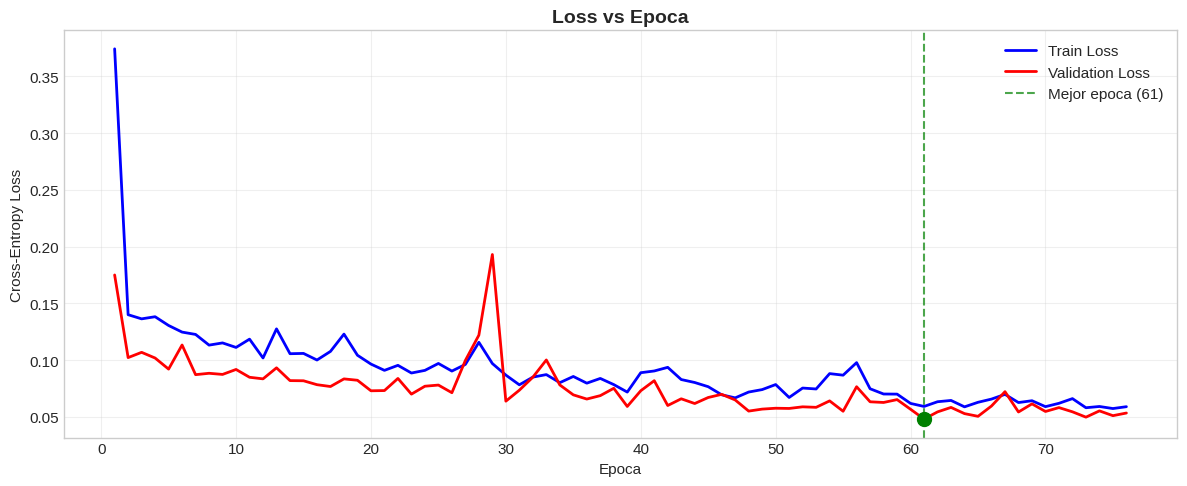

Mejor epoca: 61
Mejor val_loss: 0.0480


In [21]:
epochs_range = range(1, len(history['train_loss']) + 1)
best_epoch = np.argmin(history['val_loss']) + 1

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax.plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax.axvline(best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Mejor epoca ({best_epoch})')
ax.scatter(best_epoch, min(history['val_loss']), color='green', s=100, zorder=5)

ax.set_title('Loss vs Epoca', fontsize=14, weight='bold')
ax.set_xlabel('Epoca')
ax.set_ylabel('Cross-Entropy Loss')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mejor epoca: {best_epoch}")
print(f"Mejor val_loss: {min(history['val_loss']):.4f}")

## 8.2 Curvas de Accuracy

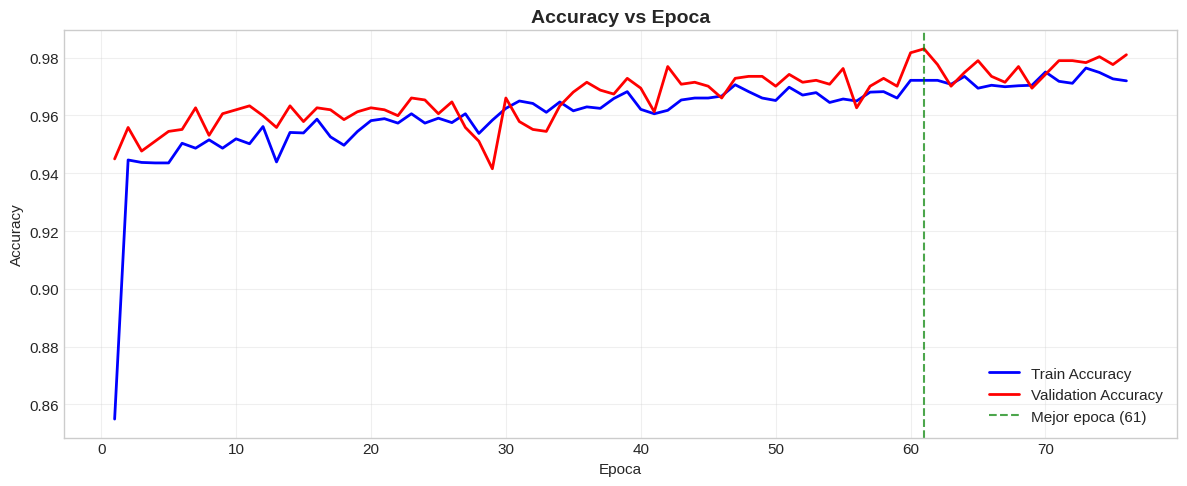


Resultados en la mejor epoca (61):
  Train Accuracy: 0.9721
  Val Accuracy:   0.9830


In [22]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(epochs_range, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
ax.plot(epochs_range, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
ax.axvline(best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Mejor epoca ({best_epoch})')

ax.set_title('Accuracy vs Epoca', fontsize=14, weight='bold')
ax.set_xlabel('Epoca')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResultados en la mejor epoca ({best_epoch}):")
print(f"  Train Accuracy: {history['train_acc'][best_epoch-1]:.4f}")
print(f"  Val Accuracy:   {history['val_acc'][best_epoch-1]:.4f}")

# 9. Evaluacion en Test Set

### Metricas de Clasificacion:

**Accuracy**: Proporcion de predicciones correctas
$$
\text{Accuracy} = \frac{\text{Correctas}}{\text{Total}}
$$

**Precision**: De las predicciones positivas, cuantas son correctas
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

**Recall**: De los casos positivos reales, cuantos detectamos
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

**F1-Score**: Media armonica de Precision y Recall
$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

In [23]:
# Evaluar en test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        predictions = outputs.argmax(dim=1).cpu().numpy()

        all_predictions.extend(predictions)
        all_labels.extend(y_batch.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calcular accuracy global
test_accuracy = (all_predictions == all_labels).mean()

print("="*70)
print("EVALUACION EN TEST SET")
print("="*70)
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*70)

# Reporte de clasificacion detallado
print("\nReporte de Clasificacion por Clase:\n")
report = classification_report(all_labels, all_predictions,
                               target_names=activity_names,
                               digits=4)
print(report)

EVALUACION EN TEST SET

Test Accuracy: 0.9328 (93.28%)

Reporte de Clasificacion por Clase:

                    precision    recall  f1-score   support

           WALKING     0.9979    0.9597    0.9784       496
  WALKING_UPSTAIRS     0.9516    0.9597    0.9556       471
WALKING_DOWNSTAIRS     0.9231    1.0000    0.9600       420
           SITTING     0.8550    0.8167    0.8354       491
          STANDING     0.8752    0.8703    0.8728       532
            LAYING     0.9908    1.0000    0.9954       537

          accuracy                         0.9328      2947
         macro avg     0.9323    0.9344    0.9329      2947
      weighted avg     0.9326    0.9328    0.9323      2947



# 10. Matriz de Confusion

### Interpretacion:

- **Diagonal**: Predicciones correctas
- **Fuera de diagonal**: Errores (confusiones entre clases)

**Utilidad**: Identificar que actividades se confunden mas

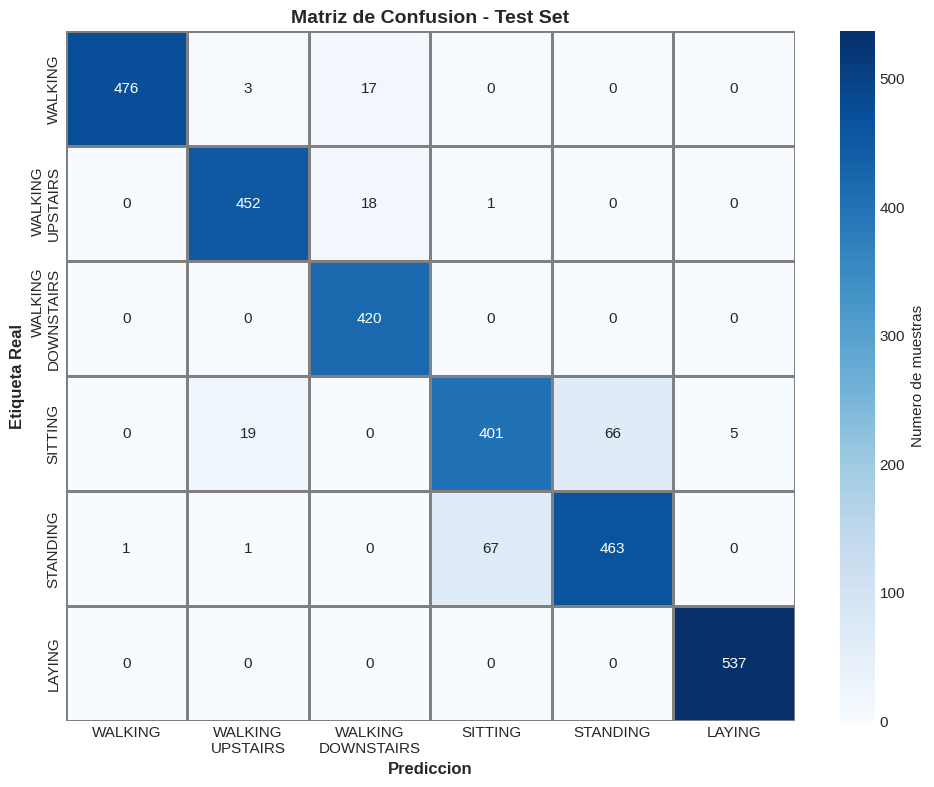

In [24]:
# Calcular matriz de confusion
cm = confusion_matrix(all_labels, all_predictions)

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[name.replace('_', '\n') for name in activity_names],
            yticklabels=[name.replace('_', '\n') for name in activity_names],
            cbar_kws={'label': 'Numero de muestras'},
            linewidths=1, linecolor='gray')

plt.title('Matriz de Confusion - Test Set', fontsize=14, weight='bold')
plt.xlabel('Prediccion', fontsize=12, weight='bold')
plt.ylabel('Etiqueta Real', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

In [25]:
# Analisis de confusiones
print("Accuracy por clase:")
print("-"*70)
for i, activity in enumerate(activity_names):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f"  {activity:20s}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

# Identificar confusiones mas comunes
print("\nConfusiones mas frecuentes:")
print("-"*70)
confusions = []
for i in range(6):
    for j in range(6):
        if i != j and cm[i, j] > 0:
            confusions.append((cm[i, j], activity_names[i], activity_names[j]))

confusions.sort(reverse=True)
for count, true_label, pred_label in confusions[:5]:
    print(f"  {true_label:20s} -> {pred_label:20s}: {count:3d} veces")

Accuracy por clase:
----------------------------------------------------------------------
  WALKING             : 0.9597 (95.97%)
  WALKING_UPSTAIRS    : 0.9597 (95.97%)
  WALKING_DOWNSTAIRS  : 1.0000 (100.00%)
  SITTING             : 0.8167 (81.67%)
  STANDING            : 0.8703 (87.03%)
  LAYING              : 1.0000 (100.00%)

Confusiones mas frecuentes:
----------------------------------------------------------------------
  STANDING             -> SITTING             :  67 veces
  SITTING              -> STANDING            :  66 veces
  SITTING              -> WALKING_UPSTAIRS    :  19 veces
  WALKING_UPSTAIRS     -> WALKING_DOWNSTAIRS  :  18 veces
  WALKING              -> WALKING_DOWNSTAIRS  :  17 veces

[Observacion]
  SITTING y STANDING se confunden frecuentemente.
  Ambas son actividades estaticas con patrones de sensor similares.


## 10.1 Metricas por Clase (Grafico)

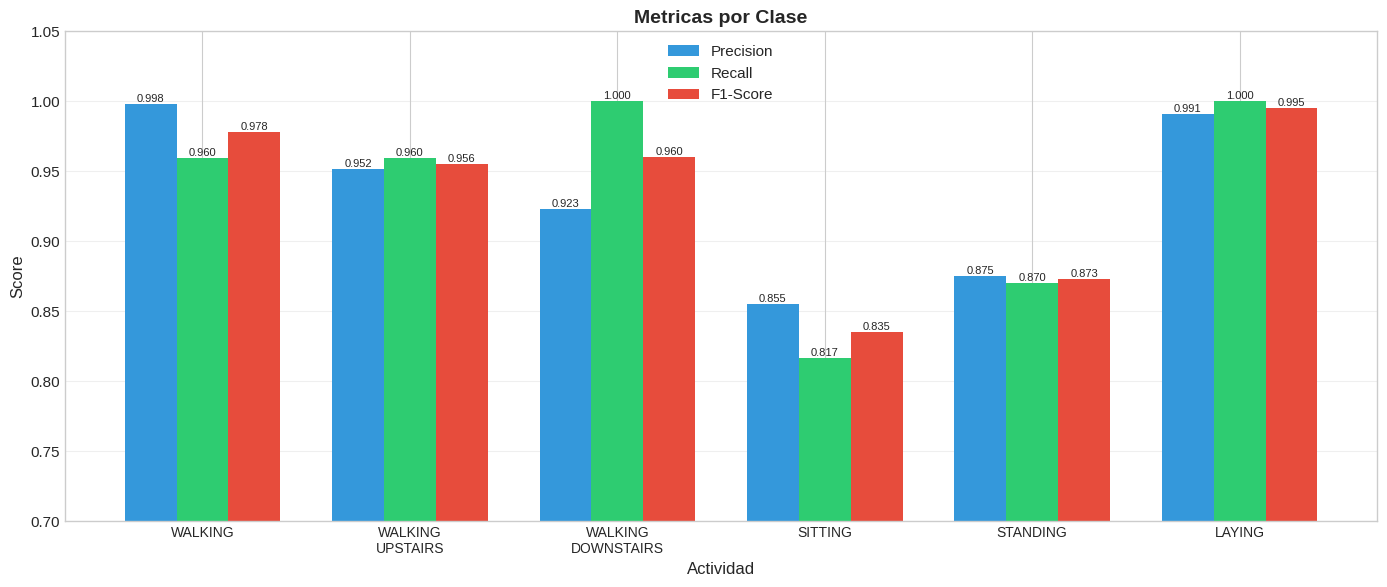


Tabla de metricas:
         Actividad  Precision   Recall  F1-Score  Muestras
           WALKING   0.997904 0.959677  0.978417       496
  WALKING_UPSTAIRS   0.951579 0.959660  0.955603       471
WALKING_DOWNSTAIRS   0.923077 1.000000  0.960000       420
           SITTING   0.855011 0.816701  0.835417       491
          STANDING   0.875236 0.870301  0.872762       532
            LAYING   0.990775 1.000000  0.995366       537


In [26]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_predictions, average=None
)

# Graficar
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(activity_names))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db')
bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c')

ax.set_title('Metricas por Clase', fontsize=14, weight='bold')
ax.set_xlabel('Actividad', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([name.replace('_', '\n') for name in activity_names], fontsize=10)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0.7, 1.05)

# Agregar valores en las barras
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}',
               ha='center', va='bottom', fontsize=8)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.tight_layout()
plt.show()

# Tabla de metricas
metrics_df = pd.DataFrame({
    'Actividad': activity_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Muestras': support
})

print("\nTabla de metricas:")
print(metrics_df.to_string(index=False))

# 11. Guardado del Modelo

### Concepto:

- `state_dict()`: Diccionario con todos los pesos del modelo
- `torch.save()`: Serializa el state_dict a disco
- `load_state_dict()`: Restaura los pesos guardados

In [27]:
# Crear directorio si no existe
model_dir = '/content/drive/MyDrive/analitica/model'
os.makedirs(model_dir, exist_ok=True)

# Guardar modelo
model_path = os.path.join(model_dir, 'har_model_best.pth')
torch.save(model.state_dict(), model_path)

print("="*70)
print("MODELO GUARDADO")
print("="*70)
print(f"Path: {model_path}")
print(f"Tamano: {os.path.getsize(model_path) / 1024 / 1024:.2f} MB")
print("="*70)

print("\nPara cargar el modelo posteriormente:")
print("")
print("  # Crear instancia del modelo")
print("  model = HARModel(n_channels=9, n_classes=6)")
print("")
print("  # Cargar pesos")
print(f"  model.load_state_dict(torch.load('{model_path}'))")
print("")
print("  # Modo evaluacion")
print("  model.eval()")

MODELO GUARDADO
Path: /content/drive/MyDrive/analitica/model/har_model_best.pth
Tamano: 4.18 MB

Para cargar el modelo posteriormente:

  # Crear instancia del modelo
  model = HARModel(n_channels=9, n_classes=6)

  # Cargar pesos
  model.load_state_dict(torch.load('/content/drive/MyDrive/analitica/model/har_model_best.pth'))

  # Modo evaluacion
  model.eval()


# 12. Conclusiones

## Resumen de Resultados

### Conceptos Clave Aplicados:

**Algebra Lineal:**
- Tensores 3D para representar series temporales multivariadas
- Convolucion como producto punto deslizante
- Transformaciones lineales en capas fully connected

**Estadistica:**
- Batch Normalization: estandarizacion (z-score) dinamica
- Distribucion de clases: balance para interpretar accuracy
- Metricas: Precision, Recall, F1 para analisis detallado

**Inteligencia Artificial:**
- CNN-1D: extraccion automatica de features temporales
- Backpropagation: calculo de gradientes con regla de la cadena
- Regularizacion: Dropout y Weight Decay para evitar overfitting
- Early Stopping: previene memorizacion del train set

In [28]:
print("="*70)
print("PROYECTO COMPLETADO")
print("="*70)

print("\nRESUMEN FINAL:")
print("-"*70)
print(f"Accuracy en Test:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Total de parametros:  {trainable_params:,}")
print(f"Epocas entrenadas:    {len(history['train_loss'])}")
print("-"*70)

print("\nOBSERVACIONES:")
print("-"*70)

if test_accuracy > 0.9:
    print("  [OK] Excelente accuracy (>90%)")
elif test_accuracy > 0.8:
    print("  [OK] Buen accuracy (>80%)")
else:
    print("  [!] Accuracy mejorable (<80%)")

final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
gap = final_train_acc - final_val_acc

if gap < 0.05:
    print("  [OK] Buena generalizacion (gap train-val < 5%)")
elif gap < 0.1:
    print("  [!] Leve overfitting (gap train-val 5-10%)")
else:
    print("  [X] Overfitting detectado (gap train-val > 10%)")

print("\n  Actividades mas confundidas:")
for count, true_label, pred_label in confusions[:3]:
    print(f"    - {true_label} -> {pred_label} ({count} veces)")

print("-"*70)

print("\nPOSIBLES MEJORAS:")
print("-"*70)
print("  1. Mas capas convolucionales para patrones mas complejos")
print("  2. Data augmentation (anadir ruido, escalar senales)")
print("  3. Probar otras arquitecturas (LSTM, Transformer)")
print("  4. Ajustar hiperparametros (learning rate, dropout)")
print("  5. Ensemble de modelos para reducir varianza")
print("-"*70)

print("\n" + "="*70)
print("Notebook completado exitosamente")
print("="*70)

PROYECTO COMPLETADO

RESUMEN FINAL:
----------------------------------------------------------------------
Accuracy en Test:     0.9328 (93.28%)
Total de parametros:  1,094,790
Epocas entrenadas:    76
----------------------------------------------------------------------

OBSERVACIONES:
----------------------------------------------------------------------
  [OK] Excelente accuracy (>90%)
  [OK] Buena generalizacion (gap train-val < 5%)

  Actividades mas confundidas:
    - STANDING -> SITTING (67 veces)
    - SITTING -> STANDING (66 veces)
    - SITTING -> WALKING_UPSTAIRS (19 veces)
----------------------------------------------------------------------

POSIBLES MEJORAS:
----------------------------------------------------------------------
  1. Mas capas convolucionales para patrones mas complejos
  2. Data augmentation (anadir ruido, escalar senales)
  3. Probar otras arquitecturas (LSTM, Transformer)
  4. Ajustar hiperparametros (learning rate, dropout)
  5. Ensemble de modelos p